## __Variational AutoEncoder__

We are going to use variational autoencoder as proposed in the source given below using MNIST dataset. In other notebooks, we will further explore Beta-VAE, VQ_VAE, Dirichlet-VAE, etc.

Source: [Kingma, D.P. and Welling, M., 2019. An introduction to variational autoencoders. _Foundations and Trends® in Machine Learning_, 12(4), pp.307-392.](https://www.nowpublishers.com/article/DownloadSummary/MAL-056)

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.transforms import v2

__MNIST__ dataset is of handwritten digits.

Here, ``test`` has $10,000$ images, and ``train`` has $60,000$ images each with $(28, 28, 1)$ shape

In [2]:
transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


In [3]:
#Creating data loaders

batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


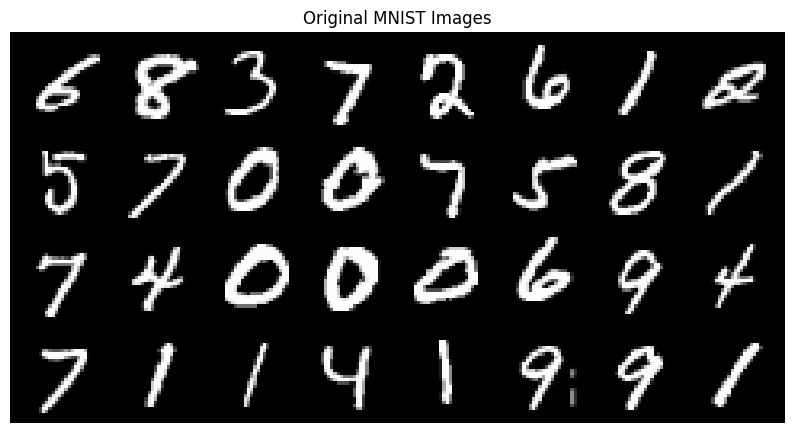

In [4]:
#visualizing some images

def show_images(images, title=None, nrow=8):

  grid = make_grid(images, nrow=nrow, padding=2, normalize=True)
  plt.figure(figsize=(10,10))
  plt.imshow(np.transpose(grid, (1,2,0))) #changing order of grid to (H, W, C)
  if title:
    plt.title(title)
  plt.axis('off')
  plt.show()

#getting new batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

#plotting images
show_images(images[:32], "Original MNIST Images")

In [5]:
#Deciding latent dimension for encoder and decoder
latent_dim = 20

In [6]:
class Encoder(nn.Module):

  def __init__(self, latent_dim = latent_dim):
    super(Encoder, self).__init__()
    self.conv_layers = nn.Sequential(
      nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias =False),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False), # Output: 128 x 4 x 4
      nn.BatchNorm2d(128),
      nn.ReLU(),
    )
    self.fc_mean = nn.Linear(128 * 4 * 4, latent_dim)
    self.fc_log_variance = nn.Linear(128 * 4 * 4, latent_dim)

  def forward(self, x):
    x = self.conv_layers(x)
    x = x.view(x.size(0), -1)  # Flatten the tensor
    mean = self.fc_mean(x)
    log_variance = self.fc_log_variance(x)
    return mean, log_variance



In [7]:
from torchsummary import summary
print("Encoder Summary:\n")
summary(Encoder(), input_size=(1, 28, 28))


Encoder Summary:

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             288
       BatchNorm2d-2           [-1, 32, 14, 14]              64
              ReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4             [-1, 64, 7, 7]          18,432
       BatchNorm2d-5             [-1, 64, 7, 7]             128
              ReLU-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 4, 4]          73,728
       BatchNorm2d-8            [-1, 128, 4, 4]             256
              ReLU-9            [-1, 128, 4, 4]               0
           Linear-10                   [-1, 20]          40,980
           Linear-11                   [-1, 20]          40,980
Total params: 174,856
Trainable params: 174,856
Non-trainable params: 0
----------------------------------------------------------------
Input size (

In [8]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 128*4*4)

        self.conv_trans_layers = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1,output_padding=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 128, 4, 4)
        x = self.conv_trans_layers(x)
        return x

In [9]:
print("Decoder Summary:\n")
summary(Decoder(), input_size=(latent_dim, ))

Decoder Summary:

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]          43,008
   ConvTranspose2d-2             [-1, 64, 7, 7]          73,728
       BatchNorm2d-3             [-1, 64, 7, 7]             128
         LeakyReLU-4             [-1, 64, 7, 7]               0
   ConvTranspose2d-5           [-1, 32, 14, 14]          18,432
       BatchNorm2d-6           [-1, 32, 14, 14]              64
         LeakyReLU-7           [-1, 32, 14, 14]               0
   ConvTranspose2d-8            [-1, 1, 28, 28]             288
           Sigmoid-9            [-1, 1, 28, 28]               0
Total params: 135,648
Trainable params: 135,648
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 0.52
Estimated Total Size (MB): 0.76
-------------------------

#### Reparameterization Trick

In [10]:
def reparameterize(mean, log_variance):
  std = torch.exp(log_variance/2)
  eps = torch.randn_like(std)
  return mean + eps*std

### Variational AutoEncoder

In [11]:
class VAE(nn.Module):
  def __init__(self, latent_dim=2):
    super(VAE, self).__init__()
    self.encoder = Encoder(latent_dim)
    self.decoder = Decoder(latent_dim)

  def forward(self, x):
    mean, log_variance = self.encoder(x)
    z = reparameterize(mean, log_variance)
    x_reconstructed = self.decoder(z)
    return x_reconstructed, mean, log_variance

### Loss Function

VAE loss has two components

__Reconstruction Loss__ given by cross entropy loss, and __KL-Divergence__



In [12]:
def vae_loss(x_reconstructed, x, mean, log_variance):
  recon_loss = F.binary_cross_entropy(x_reconstructed, x, reduction="sum")
  #KL-Divergence
  kld_loss = - 0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp())
  total_loss = recon_loss + kld_loss
  return recon_loss, kld_loss, total_loss

#### Training

In [13]:
#hyperparameters to experiment with
learning_rate = 25e-4
num_epochs = 30

model = VAE(latent_dim=latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
#training loop
import time
start = time.perf_counter()
def train(epoch):

  model.train()
  accumulated_recon_loss = 0
  accumulated_kld_loss = 0
  training_loss = 0

  for batch_idx, (data, _) in enumerate(train_loader):
    optimizer.zero_grad()
    recon_batch, mean, log_variance = model(data)
    batch_recon_loss, batch_kld_loss, batch_total_loss = vae_loss(recon_batch, data, mean, log_variance)

    batch_total_loss.backward()
    training_loss += batch_total_loss.item()
    accumulated_recon_loss += batch_recon_loss.item()
    accumulated_kld_loss += batch_kld_loss.item()
    optimizer.step()

  print(f'Epoch: {epoch} Total Loss: {training_loss / len(train_loader.dataset):.2f} '
          f'BCE Loss: {accumulated_recon_loss /len(train_loader.dataset):.2f} '
          f'KL-Divergence Loss: {accumulated_kld_loss /len(train_loader.dataset):.2f}')
for epoch in range(1, num_epochs + 1):
  train(epoch)

end = time.perf_counter()
s2mps = lambda s: f"{s // 60:.0f} min {s % 60:.2f} s"
print(f"Total Training Time: {s2mps(end - start)}")

Epoch: 1 Total Loss: 144.33 BCE Loss: 121.13 KL-Divergence Loss: 23.20
Epoch: 2 Total Loss: 108.93 BCE Loss: 83.40 KL-Divergence Loss: 25.53
Epoch: 3 Total Loss: 106.15 BCE Loss: 80.50 KL-Divergence Loss: 25.65
Epoch: 4 Total Loss: 104.67 BCE Loss: 79.05 KL-Divergence Loss: 25.62
Epoch: 5 Total Loss: 103.78 BCE Loss: 78.18 KL-Divergence Loss: 25.60
Epoch: 6 Total Loss: 103.08 BCE Loss: 77.53 KL-Divergence Loss: 25.55
Epoch: 7 Total Loss: 102.50 BCE Loss: 77.01 KL-Divergence Loss: 25.49
Epoch: 8 Total Loss: 102.18 BCE Loss: 76.70 KL-Divergence Loss: 25.47
Epoch: 9 Total Loss: 101.65 BCE Loss: 76.29 KL-Divergence Loss: 25.36
Epoch: 10 Total Loss: 101.34 BCE Loss: 76.06 KL-Divergence Loss: 25.28
Epoch: 11 Total Loss: 101.00 BCE Loss: 75.76 KL-Divergence Loss: 25.24
Epoch: 12 Total Loss: 100.65 BCE Loss: 75.44 KL-Divergence Loss: 25.20
Epoch: 13 Total Loss: 100.46 BCE Loss: 75.34 KL-Divergence Loss: 25.11
Epoch: 14 Total Loss: 100.15 BCE Loss: 75.10 KL-Divergence Loss: 25.05
Epoch: 15 Tota

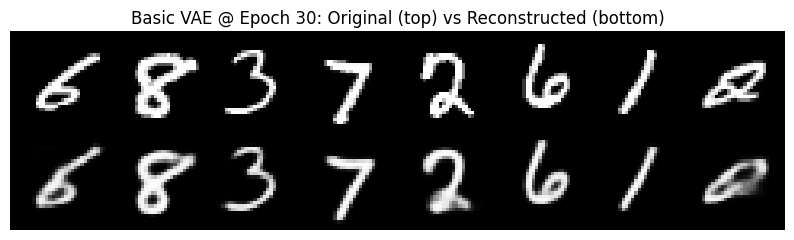

<Figure size 640x480 with 0 Axes>

In [ ]:
# reconstructing some images after last epoch
model.eval()
with torch.no_grad():
  sample = images[:8]
  recon, _, _ = model(sample)

  comparison = torch.cat([sample, recon])
  show_images(comparison, f'Basic VAE @ Epoch {epoch}: Original (top) vs Reconstructed (bottom)')
  plt.savefig('img/basic_vae.png')

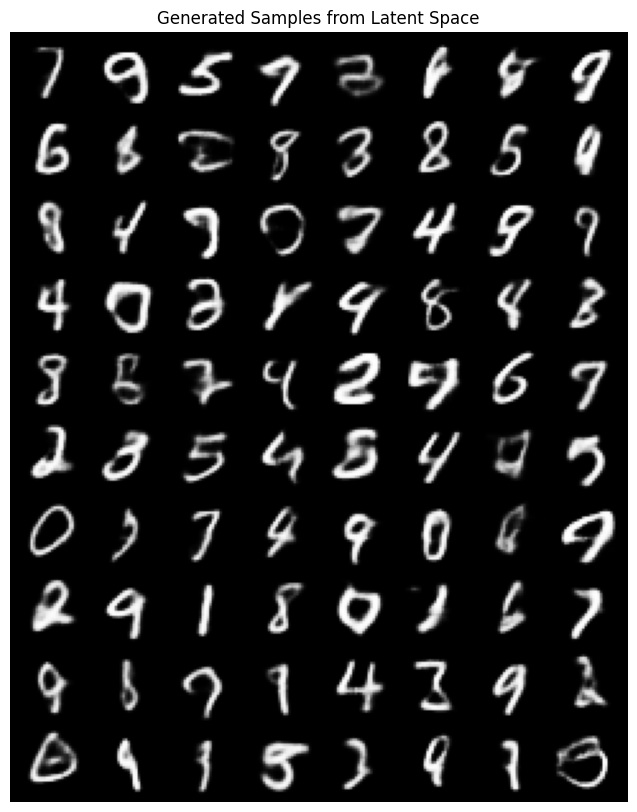

In [16]:
#generating samples from latent space
def generate_samples(model, n=80, nrow=10):
    model.eval()
    with torch.no_grad():
        # Getting the latent dimension from the model's encoder
        latent_dim = model.encoder.fc_mean.out_features
        z = torch.randn(n, latent_dim)
        samples = model.decoder(z)
        show_images(samples, "Generated Samples from Latent Space")

generate_samples(model)

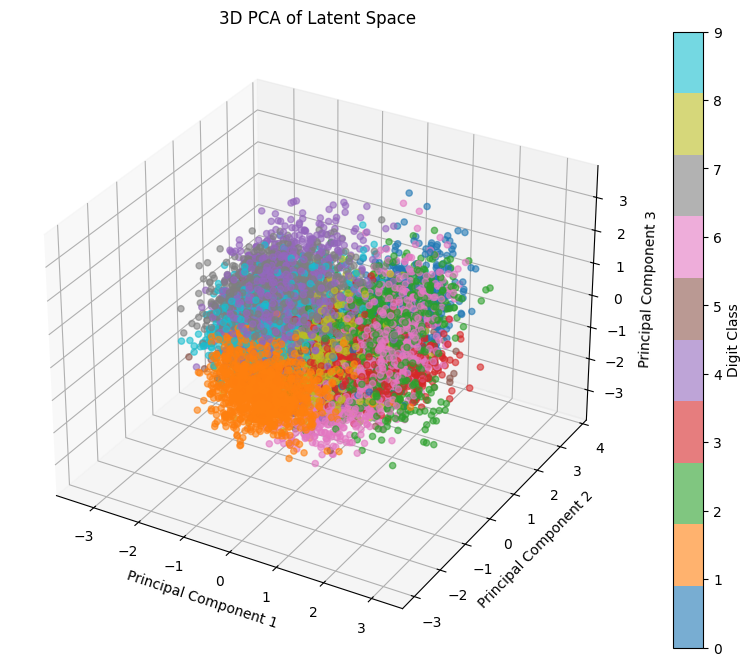

In [17]:
from sklearn.decomposition import PCA

def plot_latent_space_pca(model, data_loader, n_components=3):
    model.eval()
    latents = []
    labels = []
    with torch.no_grad():
        for data, label in data_loader:
            mean, _ = model.encoder(data)
            latents.append(mean)
            labels.append(label)

    latents = torch.cat(latents).numpy()
    labels = torch.cat(labels).numpy()

    # Performing PCA to reduce dimensionality to n_components
    pca = PCA(n_components=n_components)
    latents_reduced = pca.fit_transform(latents)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(latents_reduced[:, 0], latents_reduced[:, 1], latents_reduced[:, 2],
                        c=labels, cmap='tab10', alpha=0.6)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title('3D PCA of Latent Space')
    fig.colorbar(scatter, ticks=range(10), label='Digit Class')

    plt.show()

plot_latent_space_pca(model, test_loader, n_components=3)